# Task II: Classical Graph Neural Network (GNN) 

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://www.google.com/url?q=https://zenodo.org/record/3164691%23.YigdGt9MHrB&sa=D&source=docs&ust=1679059147452537&usg=AOvVaw0lGABn4kDxdiVfoJenxgRi) with its corresponding description. 

- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 

- Discuss the resulting performance of the 2 chosen architectures. 

In [1]:
import torch
import torch.nn as nn
import torch_geometric as geom
import torch.optim as optim
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.loader as geom_loader
import numpy as np
from tqdm import tqdm
from datetime import datetime
import pytorch_lightning as pl
import sys
import networkx as nx
from torchmetrics import AUROC
import os
import warnings
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings(
    "ignore", ".*TypedStorage is deprecated*"
)

torch.set_float32_matmul_precision("high")

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
class JetDataset(geom_data.Dataset):
    def __init__(self, root, filename, stop = None, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.stop = stop
        super(JetDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        print('processed_file_names', self.raw_paths)
        
    
        self.data = np.load(self.raw_paths[0], allow_pickle=True)
        
        self.n_graphs = min(self.stop, self.data['X'].shape[0]) if self.stop else self.data['X'].shape[0]

        if self.test:
            return [f'data_test_{i}.pt' for i in range(self.n_graphs)]
        else:
            return [f'data_{i}.pt' for i in range(self.n_graphs)]

    def download(self):
        pass

    def process(self):
        
        # DGid to small float dictionary 
        # https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/utils/data_utils.py#L188
        
        PID2FLOAT_MAP = {22: 0,
                    211: .1, -211: .2,
                    321: .3, -321: .4,
                    130: .5,
                    2112: .6, -2112: .7,
                    2212: .8, -2212: .9,
                    11: 1.0, -11: 1.1,
                    13: 1.2, -13: 1.3,
                    0: 0,}
        
        self.data = np.load(self.raw_paths[0], allow_pickle=True)
        X = self.data['X']
        y = self.data['y']
        
        pids = np.unique(X[:, :, 3].flatten())
        for pid in tqdm(pids):
            np.place(X[:, :, 3], X[:, :, 3] == pid, PID2FLOAT_MAP[pid])
            
        for i in tqdm(range(self.n_graphs)):
            jet_data = X[i]
            jet_label = y[i]
            
            _jet_data = jet_data[~np.all(jet_data == 0, axis = 1)] # Remove zero padded entries
        
            # Centering jets and normalizing pT
            yphi_avg = np.average(_jet_data[:,1:3], weights=_jet_data[:,0], axis=0)
            _jet_data[:,1:3] -= yphi_avg
            _jet_data[:, 0] /= np.sum(_jet_data[:, 0])

            # Sort by pT (0th column)
            _jet_data = _jet_data[_jet_data[:,0].argsort()][::-1].copy()
            
            # Get node features
            node_feats = self._get_node_features(_jet_data)
            
            # Get adjacency info
            edge_index = self._get_adjacency_info(_jet_data)
            
            # Get labels info
            label = self._get_labels(jet_label)
            
            # Create data object
            data = geom_data.Data(x=node_feats, 
                        edge_index=edge_index,
                        y=label)
            
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{i}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{i}.pt'))


    def _get_node_features(self, jet_data):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        
        return torch.tensor(jet_data, dtype=torch.float)

    def _get_adjacency_info(self, jet_data):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        
        pt_order = jet_data[:,0].argsort()[::-1]
        rapidity_order = jet_data[:,1].argsort()[::-1]
        eta_order = jet_data[:,2].argsort()[::-1]
        
        in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1], eta_order[:-1]))
        out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ], eta_order[1: ]))
        
        edge_indices = np.stack((in_node, out_node), axis= 0)
        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.to(torch.long).view(2, -1)
        edge_indices = geom.utils.to_undirected(edge_indices)
        edge_indices = geom.utils.add_self_loops(edge_indices)[0]
        
        return edge_indices
       
    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.n_graphs

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

In [4]:
dataset = JetDataset(root = 'data/', filename='QG_jets.npz')

processed_file_names ['data/raw/QG_jets.npz']


In [5]:
dataset

JetDataset(100000)

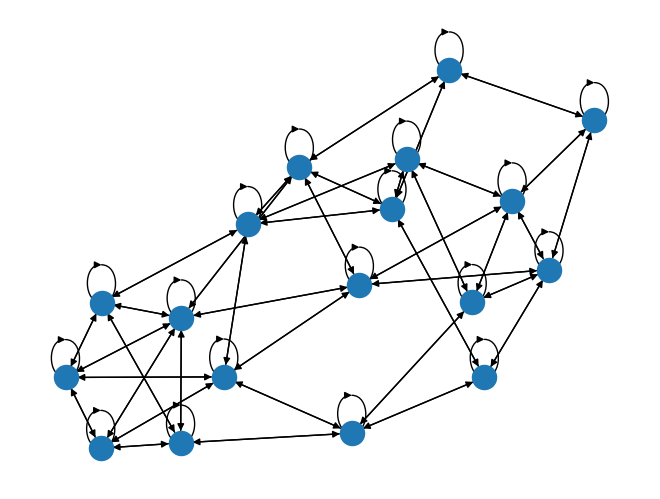

In [6]:
nx.draw(geom.utils.to_networkx(dataset[0]))

In [7]:
dataset[0]

Data(x=[18, 4], edge_index=[2, 96], y=[1])

In [8]:
n_graphs = len(dataset)
n_graphs

100000

In [9]:
dataset[0]

Data(x=[18, 4], edge_index=[2, 96], y=[1])

In [10]:
train_size = int(n_graphs * 0.6)
val_size = int(n_graphs * 0.2)
test_size = n_graphs - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                                         (train_size, val_size, test_size))

In [11]:
len(train_dataset), len(val_dataset), len(test_dataset)

(60000, 20000, 20000)

In [12]:
batch_size = 256
train_dataloader = geom_loader.DataLoader(train_dataset, 
                                          batch_size = batch_size,
                                          num_workers = 12,
                                          shuffle=True)
val_dataloader = geom_loader.DataLoader(val_dataset, 
                                        batch_size = batch_size, 
                                        num_workers = 12,
                                        shuffle=False)
test_dataloader = geom_loader.DataLoader(test_dataset, 
                                         batch_size = batch_size,
                                         num_workers = 12,
                                         shuffle=False)

In [13]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
}

In [14]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph 
            (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [15]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph 
            (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

In [16]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.task = 'binary'
        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()
        self.train_auc = AUROC(task=self.task)
        self.val_auc = AUROC(task=self.task)
        self.test_auc = AUROC(task=self.task)

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.1, weight_decay=0.0)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=0.1, total_steps=100
        )
        return  {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_auc"}

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch, mode="train")
        loss = self.loss_module(logits, batch.y.float())
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        self.train_auc(logits, batch.y)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=True,batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch, mode="val")
        loss = self.loss_module(logits, batch.y.float())
        self.log("val_loss", loss, prog_bar=True, batch_size=batch_size)
        self.val_auc(logits, batch.y)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, batch, batch_idx):
        logits = self.forward(batch, mode="val")
        self.test_auc(logits, batch.y)
        self.log("test_auc", self.test_auc, on_step=False, on_epoch=True, batch_size=batch_size)

In [17]:
logger = pl.loggers.CSVLogger(save_dir='csv_logs',version='gcn')
checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=5,
        save_weights_only=True,
        mode="max",
        monitor="val_auc"
    )
summary_callback = pl.callbacks.ModelSummary(max_depth=10)
callbacks = [summary_callback, checkpoint_callback]

In [18]:
trainer = pl.Trainer(callbacks=callbacks,
                     accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                     devices=1,
                     enable_model_summary=False,
                     logger = logger,
                     max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
model_gcn = GraphLevelGNN(c_in = dataset.num_node_features,
                      c_hidden = 16,
                      c_out=1,  # num classes = 2
                      num_layers=2,
                      layer_name="GCN")

In [ ]:
trainer.fit(model_gcn, train_dataloader, val_dataloader)

/home/gopald/Documents/QMLHEP-Tasks-2023/qmlhep/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory csv_logs/lightning_logs/gcn/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type              | Params
----------------------------------------------------------------------
0  | model                          | GraphGNNModel     | 369   
1  | model.GNN                      | GNNModel          | 352   
2  | model.GNN.layers               | ModuleList        | 352   
3  | model.GNN.layers.0             | GCNConv           | 80    
4  | model.GNN.layers.0.aggr_module | SumAggregation    | 0     
5  | model.GNN.layers.0.lin         | Linear            | 64    
6  | model.GNN.layers.1             | ReLU              | 0     
7  | model.GNN.layers.2             | Dropout           | 0  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [28]:
# Test best model on validation and test set
val_result = trainer.test(model_gcn, val_dataloader, verbose=False)
test_result = trainer.test(model_gcn, test_dataloader, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [29]:
val_result

[{'test_auc': 0.86024409532547}]

In [30]:
test_result

[{'test_auc': 0.8583213686943054}]

In [31]:
df = pd.read_csv('csv_logs/lightning_logs/gcn/metrics.csv')

In [32]:
df_grp = df.groupby('epoch').mean()

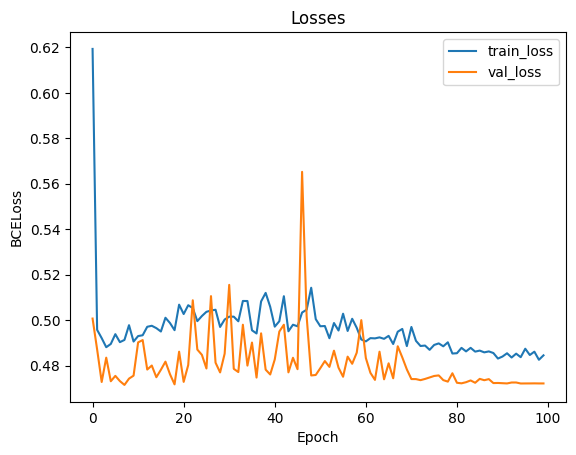

In [33]:
plt.plot(df_grp.index, df_grp['train_loss'])
plt.plot(df_grp.index, df_grp['val_loss'])
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('BCELoss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

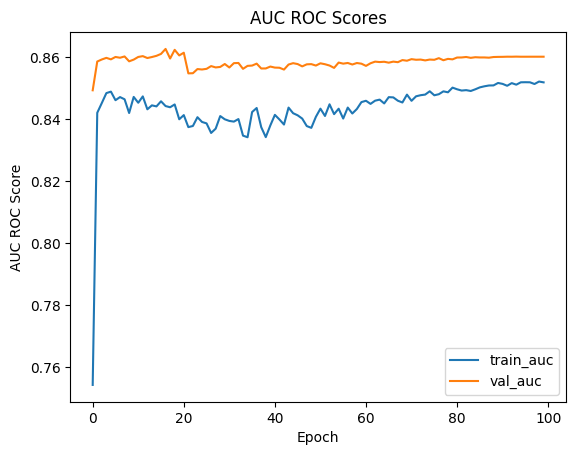

In [34]:
plt.plot(df_grp.index, df_grp['train_auc'])
plt.plot(df_grp.index, df_grp['val_auc'])
plt.title('AUC ROC Scores')
plt.xlabel('Epoch')
plt.ylabel('AUC ROC Score')
plt.legend(['train_auc', 'val_auc'])
plt.show()

In [35]:
logger = pl.loggers.CSVLogger(save_dir='csv_logs',version='gat')
checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=5,
        save_weights_only=True,
        mode="max",
        monitor="val_auc"
    )
summary_callback = pl.callbacks.ModelSummary(max_depth=10)
callbacks = [summary_callback, checkpoint_callback]

In [36]:
trainer = pl.Trainer(callbacks=callbacks,
                     accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                     devices=1,
                     enable_model_summary=False,
                     logger = logger,
                     max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
model_gat = GraphLevelGNN(c_in = dataset.num_node_features,
                      c_hidden = 16,
                      c_out=1,  # num classes = 2
                      num_layers=2,
                      layer_name="GAT")

In [38]:
trainer.fit(model_gat, train_dataloader, val_dataloader)

/home/gopald/Documents/QMLHEP-Tasks-2023/qmlhep/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory csv_logs/lightning_logs/gat/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type              | Params
----------------------------------------------------------------------
0  | model                          | GraphGNNModel     | 433   
1  | model.GNN                      | GNNModel          | 416   
2  | model.GNN.layers               | ModuleList        | 416   
3  | model.GNN.layers.0             | GATConv           | 112   
4  | model.GNN.layers.0.aggr_module | SumAggregation    | 0     
5  | model.GNN.layers.0.lin_src     | Linear            | 64    
6  | model.GNN.layers.1             | ReLU              | 0     
7  | model.GNN.layers.2             | Dropout           | 0  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
# Test best model on validation and test set
val_result = trainer.test(model_gat, val_dataloader, verbose=False)
test_result = trainer.test(model_gat, test_dataloader, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [46]:
val_result

[{'test_auc': 0.8624292612075806}]

In [47]:
test_result

[{'test_auc': 0.8603084087371826}]

In [48]:
df = pd.read_csv('csv_logs/lightning_logs/gat/metrics.csv')
df_grp = df.groupby('epoch').mean()

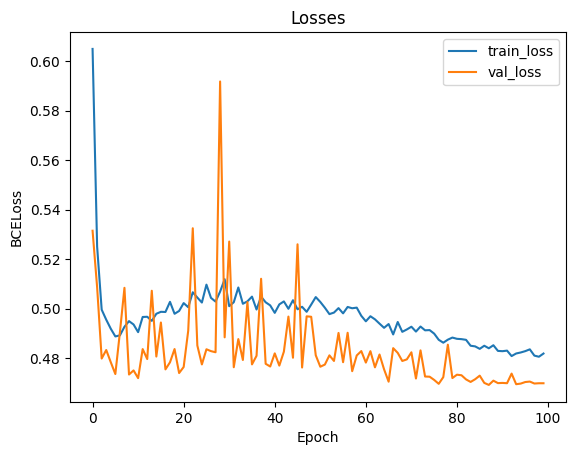

In [49]:
plt.plot(df_grp.index, df_grp['train_loss'])
plt.plot(df_grp.index, df_grp['val_loss'])
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('BCELoss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

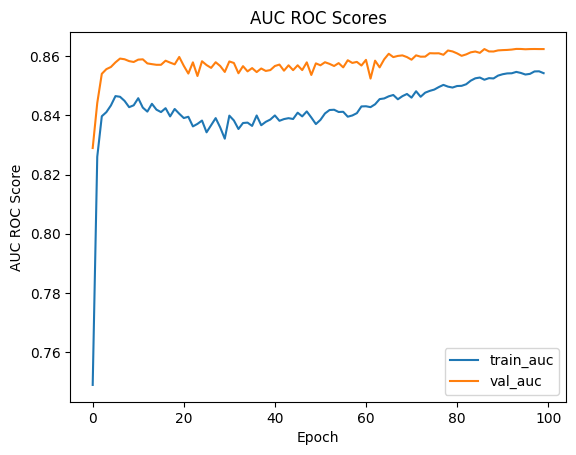

In [50]:
plt.plot(df_grp.index, df_grp['train_auc'])
plt.plot(df_grp.index, df_grp['val_auc'])
plt.title('AUC ROC Scores')
plt.xlabel('Epoch')
plt.ylabel('AUC ROC Score')
plt.legend(['train_auc', 'val_auc'])
plt.show()